## Classifying images using the CINIC-10

Giovanne Lucas, 173317, g173317@dac.unicamp.br
Celso Mizerani, , mizeranicelso@gmail.com

O objetivo deste trabalho é explorar as técnicas de classificação de regressão logística multi-classe e rede neural para determinar a melhor solução para o problema da classificação de imagens da base de dados CINIC-10, evitando overfitting.

Boa parte do código aqui apresentado foi inspirado e adaptado dos trabalhos:

https://www.pugetsystems.com/labs/hpc/Machine-Learning-and-Data-Science-Multinomial-Multiclass-Logistic-Regression-1007/
https://dataaspirant.com/2017/05/15/implement-multinomial-logistic-regression-python/
https://github.com/erikperillo/ml-2sem2019/blob/master/notebooks/logreg-demo_2019-08-26/Trying%20out%20Logistic%20Regression.ipynb
http://rasbt.github.io/mlxtend/user_guide/classifier/SoftmaxRegression/

In [1]:
import pandas as pd  # data handeling
import numpy as np   # numerical computing
import time

#plotting utilities
from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib import colors as mpl_colors
plt.rcParams['figure.figsize'] = [15, 10]
style.use('ggplot')

1º Passo: preparar os dados para a aplicação das técnicas

In [2]:
# function to artificially insert the bias (x0) for both models into the data as a new feature
def prepend_ones(xs):
    ones = np.ones(shape=(xs.shape[0], 1), dtype=xs.dtype)
    return np.concatenate([ones, xs], axis=1)

# extract and prepare data for training validation and test
trainSet = np.load('train.npz')
x_train, y_train = trainSet['xs'].astype(float), trainSet['ys'].astype(float)
x_train = prepend_ones(x_train)

valSet = np.load('val.npz')
x_val, y_val = valSet['xs'].astype(float), valSet['ys'].astype(float)
x_val = prepend_ones(x_val)

testSet = np.load('test.npz')
x_test, y_test = testSet['xs'].astype(float), testSet['ys'].astype(float)
x_test = prepend_ones(x_test)

In [3]:
# prints data
print('x_train.shape: ', x_train.shape, '\ny_train.shape: ', y_train.shape)
print('x_train:\n', x_train)
print('y_train:\n', y_train)
print('x_val.shape: ', x_val.shape, '\ny_val.shape: ', y_val.shape)
print('x_val:\n', x_val)
print('y_val:\n', y_val)
print('x_test.shape: ', x_test.shape, '\ny_test.shape: ', y_test.shape)
print('x_test:\n', x_test)
print('y_test:\n', y_test)

x_train.shape:  (80000, 3073) 
y_train.shape:  (80000,)
x_train:
 [[  1. 119.  13. ...  81.  76.  76.]
 [  1. 255. 255. ...  72.  82.  69.]
 [  1.  91.  74. ... 103.  74.  35.]
 ...
 [  1.   1.   1. ...  45.  38.  30.]
 [  1. 149. 101. ... 143. 143. 143.]
 [  1. 170. 189. ... 140. 140. 132.]]
y_train:
 [1. 9. 6. ... 3. 5. 0.]
x_val.shape:  (10000, 3073) 
y_val.shape:  (10000,)
x_val:
 [[  1. 102. 107. ... 118. 120. 130.]
 [  1. 114. 121. ... 115. 108. 100.]
 [  1. 224. 248. ... 128. 142.  81.]
 ...
 [  1.   5.   5. ...   1.   1.   4.]
 [  1. 241. 240. ... 100.  88.  72.]
 [  1. 136. 178. ...  34.  49.  15.]]
y_val:
 [9. 0. 7. ... 0. 9. 9.]
x_test.shape:  (10000, 3073) 
y_test.shape:  (10000,)
x_test:
 [[  1.  84. 125. ...  73.  89.  21.]
 [  1. 179. 204. ... 170. 161. 140.]
 [  1. 190. 184. ... 156. 152. 143.]
 ...
 [  1. 138.  91. ... 116. 163.  50.]
 [  1. 251. 253. ... 186. 205. 215.]
 [  1. 196. 229. ...  34.  47.  55.]]
y_test:
 [6. 9. 3. ... 1. 8. 0.]


2º Passo: preparar os valores de classe em one-hot encoding para a aplicação das técnicas

In [4]:
y_train = (np.arange(np.max(y_train) + 1) == y_train[:, None]).astype(float)
y_test = (np.arange(np.max(y_test) + 1) == y_test[:, None]).astype(float)
y_val = (np.arange(np.max(y_val) + 1) == y_val[:, None]).astype(float)

print('one-hot encoding of y_train:\n', y_train.shape, '\n', y_train)
print('one-hot encoding of y_val:\n', y_val.shape, '\n', y_val)
print('one-hot encoding of y_test:\n', y_test.shape, '\n', y_test)

one-hot encoding of y_train:
 (80000, 10) 
 [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
one-hot encoding of y_val:
 (10000, 10) 
 [[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
one-hot encoding of y_test:
 (10000, 10) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


Uma amostra que pertence à classe 0 (primeira coluna) tem um 1 em sua primeira posição e zero nas demais, uma amostra que pertence à classe 1 tem um 1 em sua segunda posição e zero nas demais, e assim por diante...

3º Passo: implementar as equações que determinam o funcionamento da regressão logística

In [5]:
# main Logistic Regression equations
def log(z, eps=1e-32):  # numerically stable log
    return np.log(np.maximum(z, eps))

def sigmoid(z) :  # sigmoid function
    return 1.0/(1.0 + np.exp(-z))

def h_logistic(x, theta):
    '''Hypothesis function'''
    z = np.dot(x, theta)
    return sigmoid(z)

def softmax(z):
    exp = np.exp(z)
    test_sum = np.sum(exp, axis=1, keepdims=True)
    return exp/test_sum

In [6]:
# testing weight matrix creation and LR equations
w = np.zeros(shape=(x_train.shape[1],10)).astype(float)
print('weights matrix example for the problem:\n', w)
hyp = h_logistic(x_val, w)
print('hypothesis example for validation batch:\n', hyp)
smax = softmax(hyp)
print('softmax example for validation batch:\n', smax)

weights matrix example for the problem:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
hypothesis example for validation batch:
 [[0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 ...
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]]
softmax example for validation batch:
 [[0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 ...
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]]


Agora, vamos definir a matriz de features dos nossos 80000 exemplos de treino. Assumimos, portanto, u ma base de dados com 3072 features (pixels) e 1 bias, de forma que temos uma matriz 80000x3073 para os exemplos. Da mesma forma, criamos uma matriz de pesos 3073x10 que conecta cada uma das features às classes.

4º Passo: implementar as funções que serão utilizadas para executar a descida do gradiente

In [7]:
# function to compare results i the future
def choice(z):
    return z.argmax(axis=1)

# more logistic regression equations, now for gradient descent
def cross_entropy(y_true, y_pred):
    return - np.sum(log(y_pred) * (y_true), axis=1)

xent = cross_entropy(y_val, smax)
print('Cross Entropy example for valisation batch:\n', xent.shape, '\n', xent)

def cost(y_true, y_pred):
    return np.mean(cross_entropy(y_true, y_pred))

J_cost = cost(y_val, smax)
print('Cost: example for valisation batch: ', J_cost)

def squared_error(y_true, y_pred):
    return (y_true - y_pred)**2

print('squared_error:\n', squared_error(y_val, smax).shape, '\n', squared_error(y_val, smax))

Cross Entropy example for valisation batch:
 (10000,) 
 [2.30258509 2.30258509 2.30258509 ... 2.30258509 2.30258509 2.30258509]
Cost: example for valisation batch:  2.3025850929940463
squared_error:
 (10000, 10) 
 [[0.01 0.01 0.01 ... 0.01 0.01 0.81]
 [0.81 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.81 0.01 0.01]
 ...
 [0.81 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.81]
 [0.01 0.01 0.01 ... 0.01 0.01 0.81]]


In [8]:
# more logistic regression equations, yet for gradient descent
def cost_derivative(x, y_true, y_pred):
    #print('y_pred - y_true:\n', ueh)
    #print('cost_derivative:\n', np.dot(x.T, (y_pred - y_true)))
    return np.dot(x.T, (y_pred - y_true))

#def cost_derivative(x, y_true, y_pred):
#    m = y.size
#    return -(np.sum(log(y_pred)) + np.dot((y_true-1).T,(np.dot(x,a))))/m

def gradient_descent_step(x, y_true, y_pred, theta, learning_rate):
    grad = cost_derivative(x, y_true, y_pred)
    #print('grad:\n', grad)
    step = grad * learning_rate
    #print('step:\n', step)
    theta[:] = theta - step
    #print('new theta:\n', theta)
    return theta

In [9]:
# more logistic regression equations, yet for gradient descent
def forward_step(x, y, theta):
    '''Predicts using given theta and calculates loss'''
    #print('forward_step theta:\n', theta)
    y_pred = h_logistic(x, theta)
    y_pred = softmax(y_pred)
    loss = cost(y, y_pred)
    return y_pred, loss


def gradient_descent(x, y, x_val, y_val, theta, learning_rate, n_epochs):
    #initial values for losses and best theta
    best_theta = theta.copy()
    y_pred, loss = forward_step(x, y, theta)
    _, val_loss = forward_step(x_val, y_val, theta)
    best_val_loss = val_loss

    #evolution of train/validation loss along epochs
    history = {'loss': [loss], 'val_loss': [val_loss]}
    
    #main gradient descent loop
    for k in range(n_epochs):
        #adjust weights
        theta = gradient_descent_step(x, y, y_pred, theta, learning_rate)

        #computing losses for new weights
        y_pred, loss = forward_step(x, y, theta)
        _, val_loss = forward_step(x_val, y_val, theta)
        
        #if validation loss is the best so far, saves weights
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_theta = theta.copy()

        #appending losses to history
        history['loss'].append(loss)
        history['val_loss'].append(val_loss)
        
        print(f'[epoch #{k+1:04d}/{n_epochs:04d}',
            f'loss: {loss:.4f} | val loss: {val_loss:.4f}', end='\r')
    print()

    return best_theta, history

In [10]:
# training routine using gradient descent
def train(x_train, y_train, x_val, y_val, learning_rate, n_epochs):
    #initial theta
    start = time.time()
    
    rand = np.random.RandomState(seed=None)
    sigma = np.sqrt(2/(x_train.shape[1] + 1))
    theta = sigma*rand.randn(x_train.shape[1], 10)
    #theta = np.zeros((x_train.shape[1], 10))

    #gradient descent optimization
    theta, history = gradient_descent(
        x_train, y_train, x_val, y_val,
        theta, learning_rate, n_epochs)

    elapsed = time.time() - start
    print(f'training elapsed time for vectorized gradient descent: {elapsed:.4f}s')
    return theta, history

In [11]:
# plotting definitions
def get_colors():
    colors = [
        '#348ABD',
        '#E24A33',
        '#A60628',
        '#467821',
        '#CF4457',
        '#7A68A6',
        '#188487',
    ]
    init_colors = set(colors)
    other_colors = sorted(mpl_colors.cnames.keys())
    colors.extend(c for c in other_colors if c not in init_colors)
    return colors


def plot_train_history(hist):
    keys = sorted(hist.keys())
    for k, c in zip(keys, get_colors()):
        plt.plot(hist[k], color=c)
    plt.legend(keys, loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('metric')
    plt.title('train metrics')
    plt.show()

5º Passo: executar o treino com base nos dados de treino e validação

[epoch #0120/0120 loss: 2.1324 | val loss: 2.1376
training elapsed time for vectorized gradient descent: 103.5493s


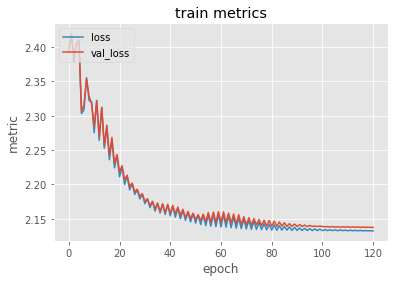

In [12]:
theta, history = train(
    x_train, y_train, x_val, y_val,
    learning_rate=0.001,
    n_epochs=120
)
plot_train_history(history)

6º Passo: determinar uma medida de precisão para o modelo treinado nos casos de treino, validação e teste

In [13]:
y_pred, loss = forward_step(x_train, y_train, theta)
pred = choice(y_pred)
value = choice(y_train)
summ = float(0)
for i in range(value.shape[0]):
    if pred[i] == value[i]:
        summ += 1
acc = summ/value.shape[0]
print('training accuracy: ', acc)

training accuracy:  0.154675


In [14]:
y_pred, loss = forward_step(x_val, y_val, theta)
pred = choice(y_pred)
value = choice(y_val)
summ = float(0)
for i in range(value.shape[0]):
    if pred[i] == value[i]:
        summ += 1
acc = summ/value.shape[0]
print('validation accuracy: ', acc)

validation accuracy:  0.1551


In [15]:
y_pred, loss = forward_step(x_test, y_test, theta)
pred = choice(y_pred)
value = choice(y_test)
summ = float(0)
for i in range(value.shape[0]):
    if pred[i] == value[i]:
        summ += 1
acc = summ/value.shape[0]
print('test accuracy: ', acc)

test accuracy:  0.1521


In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

ModuleNotFoundError: No module named 'keras'

In [ ]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(6146‬, input_dim=2073, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=1000, verbose=0)

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)

In [ ]:
results = cross_val_score(estimator, x_test, y_test, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))